---
## Classifier  
---
### Content
---

- **[Libraries to use](#Libraries_to_use)**

- **[Loading the dataset](#Loading_dataset)**

- **[Cleaning the dataset and extracting required features](#Cleaning_extracting)**

- **[Including reversed findings to the dataset](#Reversed_findings)**

- **[Creating a dictionary with train, test, validation datasets](#train_test_validation)**

- **[Load tokenizer and model](#tokenizer_model)**

- **[Tokenize the datasets](#tokenize)**

- **[Formating to torch](#Formating)**

- **[Extracting hidden states](#Extracting_hidden_states)**

- **[Creating a feature matrix](#feature_matrix)**

- **[Visualizing the training set](#Visualizing_training)**

- **[Training a classifier](#Training_classifier)**

 ---

---
### Libraries to use <a id="Libraries_to_use"> </a>
---

In [2]:
#----------------------------------------------------------
# Regular modules

#----------------------------------------------------------
import numpy as np

import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#----------------------------------------------------------
# Visualization
#----------------------------------------------------------
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#----------------------------------------------------------
# Classifiers
#----------------------------------------------------------
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
#----------------------------------------------------------
# For metrics
#----------------------------------------------------------
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
#----------------------------------------------------------
# To avoid warnings
#----------------------------------------------------------
import os
import warnings 
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#----------------------------------------------------------
# Not regular modules
#----------------------------------------------------------
import datasets # to create a dictionary of datasets.
import torch #The torch module provides support for multi-dimensional arrays called tensors.
from umap import UMAP #Uniform Manifold Approximation and Projection
# is a machine learning technique for dimensionality reduction, which is commonly
# used for visualizing high-dimensional data in two or three dimensions.
import pickle
#----------------------------------------------------------
# Transformers
#----------------------------------------------------------
from transformers import AutoTokenizer # to tokenize dataset of text.
from transformers import AutoModel # to export last hidden layer from the outputs of the model.
from transformers import AutoModelForSequenceClassification # to export logists from the outputs of the model.
#----------------------------------------------------------

In [3]:
from endogpt.Preprocessor import preprocess_real
from endogpt.Preprocessor import preprocess_synthetic
from endogpt.Classifier import train_test_validation  

<a id="Loading_dataset"> </a>

---
### Loading the dataset 
---

In [4]:
string = pd.read_csv('data/real.csv')
real = preprocess_real(string)
real=real.iloc[:100]
real = real[['findings']]
real['label'] = 0
real

,findings,label
0,Columnar lined oesophagus is present. The segm...,0
1,There is an ulcer in the stomach which is supe...,0
2,LA Grade D oesophagitis. The oesopahgitis is ...,0
3,There is a polyp in the body which is sessile ...,0
4,There is a stricture in the fundus which is Oe...,0
...,...,...
95,Large sliding hiatus hernia. NA,0
96,The patient has a polyp in the antrum which is...,0
97,Normal gastroscopy to the duodenum.,0
98,"list(""The stricture will need to be dilatated ...",0


In [5]:
real['findings'].iloc[3]

'There is a polyp in the body which is sessile with an abnormal pit pattern. A gastric polyp is seen in the pylorus, with a tubular and elongated shape and a smooth surface.The polyp was removed with minimal thermal injury to surrounding tissue using a cold snare technique..  FOLLOW UP: The patient should be advised to seek medical attention immediately if they experience severe abdominal pain, vomiting, or bloody stools. RECOMMENDATION: The patient should be advised to avoid NSAIDs and aspirin, which can increase the risk of developing more polyps.'

In [6]:
string = pd.read_csv('data/synthetic.csv')
synthetic = preprocess_synthetic(string)
synthetic = synthetic.iloc[:100]
synthetic

,findings,label
0,Detection of adhesions was lower in Group I th...,1
1,the identity is changed. Part 2. Data from scr...,1
2,Identification of varices and capsule endoscop...,1
3,gastric antrum; cardiac and supra-cardiac fold...,1
4,I significant impact on the treatment sequence...,1
...,...,...
95,adenocarcinoma was incidentally discovered by ...,1
96,50-100 lesions were detected in 33 patients (t...,1
97,Of 923 identified subjects in the gastro-oesop...,1
98,Wound response of infected burn scar with occl...,1


In [7]:
fake_real = pd.concat([synthetic, real])
fake_real.reset_index(drop=True, inplace=True)
fake_real

,findings,label
0,Detection of adhesions was lower in Group I th...,1
1,the identity is changed. Part 2. Data from scr...,1
2,Identification of varices and capsule endoscop...,1
3,gastric antrum; cardiac and supra-cardiac fold...,1
4,I significant impact on the treatment sequence...,1
...,...,...
195,Large sliding hiatus hernia. NA,0
196,The patient has a polyp in the antrum which is...,0
197,Normal gastroscopy to the duodenum.,0
198,"list(""The stricture will need to be dilatated ...",0


<a id="train_test_validation"> </a>

---
### Creating a dictionary with train, test, validation datasets 
---

In [8]:
Dict_datasets = train_test_validation(fake_real)
Dict_datasets

DatasetDict({
    train: Dataset({
        features: ['findings', 'label'],
        num_rows: 98
    })
    test: Dataset({
        features: ['findings', 'label'],
        num_rows: 60
    })
    validation: Dataset({
        features: ['findings', 'label'],
        num_rows: 42
    })
})

<a id="tokenizer_model"> </a>

---
### Load tokenizer and model 
---

- BioBERT is a pre-trained language model that is designed for biomedical natural language processing (NLP) tasks. It is based on the Google's BERT (Bidirectional Encoder Representations from Transformers) architecture.

- BioBERT is pre-trained on a large corpus of biomedical text data, which includes abstracts and full-text articles from PubMed Central and other biomedical databases. 

---

In [9]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

In [10]:
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1", num_labels=2)

<a id="tokenize"> </a>

---
### Tokenize the datasets 
---

In [11]:
#--------------------------------------------------------------------
# define function to tokenize the datasets
#--------------------------------------------------------------------
def tokenize(data):
    return tokenizer(data["findings"], padding=True, truncation=True,max_length=500) 
#--------------------------------------------------------------------
# tokenize datasets
#--------------------------------------------------------------------
Dict_datasets_encoded = Dict_datasets.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

<a id="Formating"> </a>

---
### Formating to torch 
---

In [12]:
Dict_datasets_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

<a id="Extracting_hidden_states"> </a>

---
### Extracting hidden states 
---


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}
dataset_hidden = Dict_datasets_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

<a id="feature_matrix"> </a>

---
### Creating a feature matrix 
---

We will use the hidden states as input features and the labels as targets.

In [14]:
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
X_test = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
y_test = np.array(dataset_hidden["test"]["label"])

---
### Visualizing the training set <a id="Visualizing_training"> </a>
---

In [15]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,9.575847,14.263799,0
1,9.930551,16.609842,0
2,7.783401,14.940479,0
3,12.302001,-1.804215,1
4,10.395199,13.178617,1


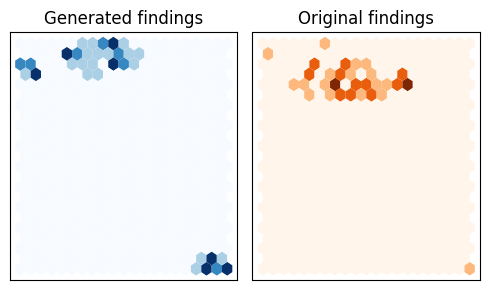

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(5,3))
axes = axes.flatten()
cmaps = ["Blues", "Oranges"]
labels = ['Generated findings','Original findings']

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

<a id="Training_classifier"> </a>

---
### Training a classifier 
---

In [17]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

LogisticRegression()

In [30]:
# Save your model
with open('model.pkl', 'wb') as file:
    pickle.dump(lr_clf, file)

### Evaluation of the classifier

In [26]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_preds = dummy_clf.predict(X_test)
accuracy =accuracy_score(y_test, y_preds)
accuracy

0.5

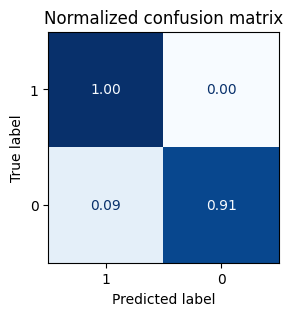

In [27]:
y_preds = lr_clf.predict(X_test)

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(3, 3))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_test,y_preds, [1,0])

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
#------------------------------------------------
accuracy =accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
#------------------------------------------------
print('accuracy:',accuracy)
print('precision:',precision)
print('recall:',recall)
print('f1:',f1)

accuracy: 0.95
precision: 0.9090909090909091
recall: 1.0
f1: 0.9523809523809523


### Error analysis

In [22]:
def single_text(lr_clf,custom_sentence,custom_label):
    #-----------------------------------------------------
    inputs = tokenizer(custom_sentence, return_tensors="pt")
    #-----------------------------------------------------
    labels = ['Real medical report','Fake medical report']
    #-----------------------------------------------------
    inputs = {k:v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
            outputs = model(**inputs)
    #outputs.last_hidden_state.shape
    #-----------------------------------------------------
    preds_prob = lr_clf.predict_proba(np.array(outputs.last_hidden_state[:,0].cpu().numpy()))
    preds = lr_clf.predict(np.array(outputs.last_hidden_state[:,0].cpu().numpy()))
    #-----------------------------------------------------
    #preds_df = pd.DataFrame(preds[0])
    #-----------------------------------------------------
    plt.figure(figsize=(6,2))
    plt.bar(labels, 100 * preds_prob[0], color='red')
    plt.title(f'"{custom_sentence[:110]}..."')
    plt.ylabel("Class probability (%)")
    plt.show()

In [1]:
from endogpt.Classifier import single_text 
custom_sentence = 'There is a polyp in the body which is sessile with an abnormal pit pattern. A gastric polyp is seen in the pylorus, with a tubular and elongated shape and a smooth surface.The polyp was removed with minimal thermal injury to surrounding tissue using a cold snare technique..  FOLLOW UP: The patient should be advised to seek medical attention immediately if they experience severe abdominal pain, vomiting, or bloody stools. RECOMMENDATION: The patient should be advised to avoid NSAIDs and aspirin, which can increase the risk of developing more polyps.'
single_text(custom_sentence)

0.9405951141622851

In [22]:
string = pd.read_csv('data/findings100.csv')
synthetic = preprocess_synthetic(string)
synthetic_dataset = datasets.Dataset.from_pandas(synthetic)
synthetic_dataset

Dataset({
    features: ['findings', 'label'],
    num_rows: 100
})

In [ ]:
def single_text_mapping(custom_sentence):
    custom_sentence=custom_sentence['findings']
    prob=single_text(custom_sentence)
    return {"proba": prob}

synthetic_prob = synthetic_dataset.map(single_text_mapping)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
synthetic_prob

In [ ]:
synthetic_prob.set_format("pandas")
synthetic_prob

In [ ]:
df_test = synthetic_prob[:]
df_test
df_test.sort_values("proba", ascending=False).tail(10)

In [ ]:
df_test.findings.iloc[81]

In [ ]:
df_test.sort_values("proba", ascending=False).head(30)

In [ ]:
df_test.findings.iloc[66]